In [1]:
import sys, pathlib
module_path = pathlib.Path("__file__").resolve().parent
sys.path.insert(0, str(module_path))

### Define the Graph Convolution Network (GCN) architecture

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes, 
                 num_hidden_layers, 
                 hidden_layer_neurons, 
                 dropout_prob, 
                ):
        
        super(GCN, self).__init__()

        # Input layer
        self.conv1 = GCNConv(num_features, hidden_layer_neurons[0])

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden_layers - 1):
            self.hidden_layers.append(GCNConv(hidden_layer_neurons[i], 
                                              hidden_layer_neurons[i + 1]))

        # Output layer
        self.fc = nn.Linear(hidden_layer_neurons[-1], 
                            num_classes)
        
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Input layer
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)

        # Hidden layers
        for layer in self.hidden_layers:
            x = F.relu(layer(x, edge_index))
            x = self.dropout(x)

        # Output layer
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

### Load the data

In [3]:
from mof_galaxy.main import get_data


# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_graph, val_graph, test_graph = get_data(device, 
                                              num_val=0.2, 
                                              num_test=0.0, 
                                              alpha=0.9, 
                                              omega=0.9)

### Train the GCN model and plot the results

Epoch 500/2000 (learning rate: 1.902e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.121, 1.115] 	 Accuracy [Train, Val]: [0.529, 0.529]

Epoch 999/2000 (learning rate: 1.827e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.113, 1.102] 	 Accuracy [Train, Val]: [0.525, 0.530]

Epoch 1498/2000 (learning rate: 1.737e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.107, 1.091] 	 Accuracy [Train, Val]: [0.530, 0.533]

Epoch 1997/2000 (learning rate: 1.652e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.092, 1.085] 	 Accuracy [Train, Val]: [0.545, 0.545]



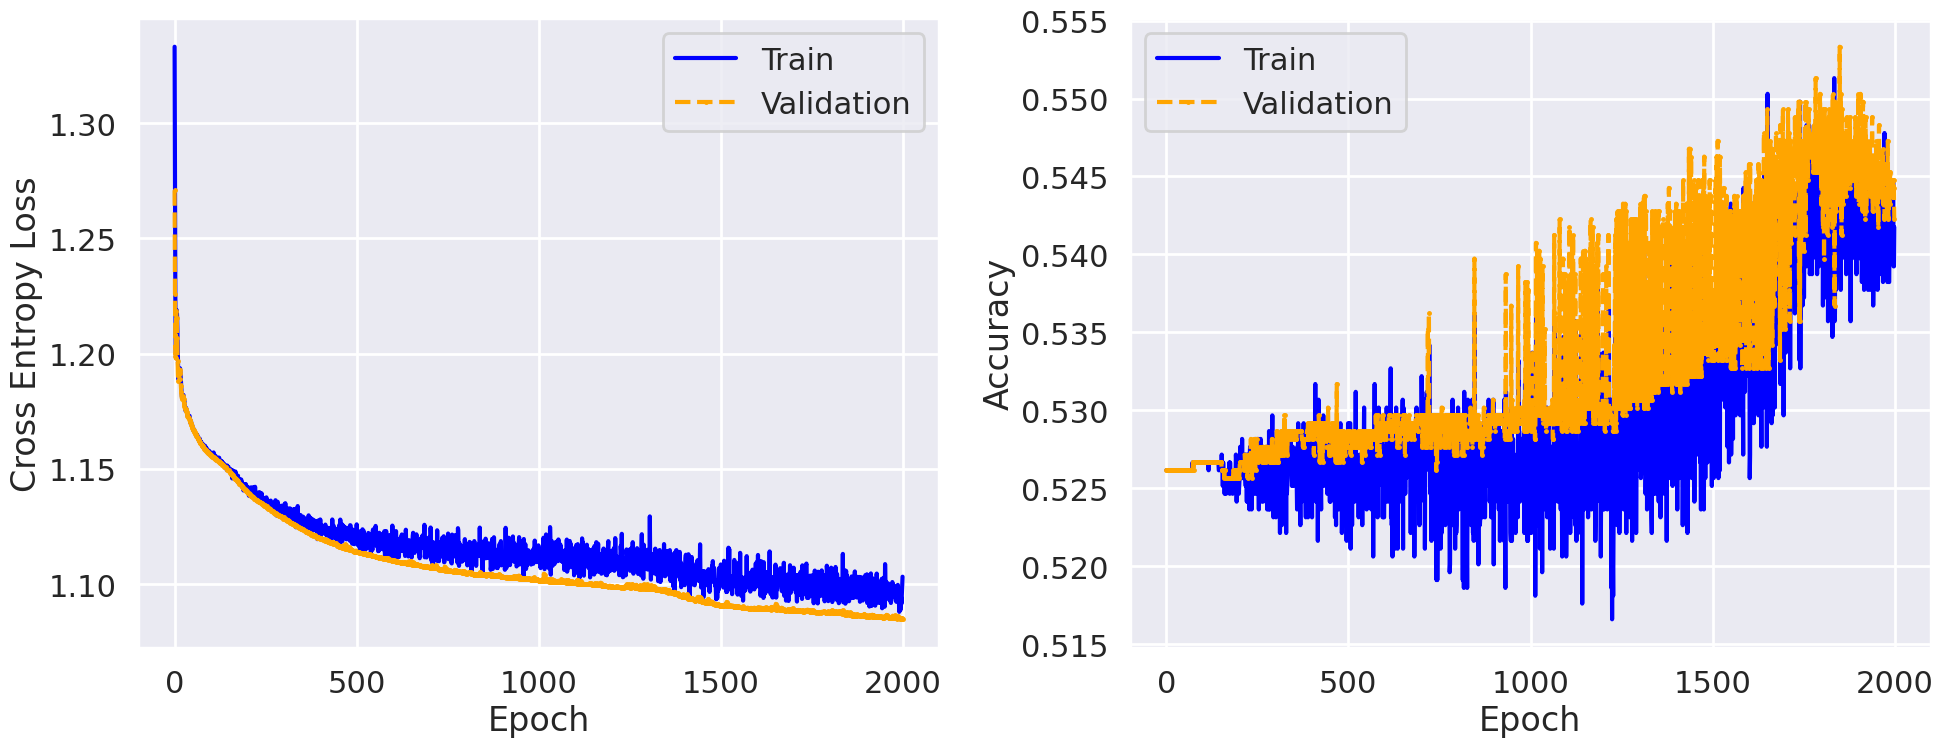

In [4]:
from mof_galaxy.main import train, plot_results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("poster")

model = GCN(num_features=train_graph.x.shape[1], 
                  num_classes=len(train_graph.y.unique()),
                  dropout_prob=0.01,
                  num_hidden_layers=1,
                  hidden_layer_neurons=[32]
                 ).to(device)

trained_model, stats = train(model,
                             train_graph=train_graph,
                             val_graph=val_graph,
                             num_epochs=2000,
                             batch_size=16, 
                             lr=0.02, 
                             lr_step=100, 
                             lr_gamma=0.99, 
                             display_freq=500
                            )

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes[0], axes[1] = plot_results(ax_loss=axes[0], ax_acc=axes[1], model_stats=stats)
plt.tight_layout()

### Hyperparameter Tuning with Optuna

#### a) Tuning number of hidden layers, hidden neurons and dropout probability in each layer 

In [5]:
%%time

import optuna

# Define the objective function for Optuna optimization
def objective_layers(trial):
    # Suggest hyperparameters to be optimized
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    hidden_layer_neurons = []
    possible_neuron_sizes = [16, 32, 64]
    for i in range(num_hidden_layers):
        num_neurons = trial.suggest_categorical(f"neurons_{i+1}", possible_neuron_sizes)
        hidden_layer_neurons.append(num_neurons)
    dropout_prob = lr = trial.suggest_float('dropout_prob', 1e-3, 1e-1, log=True)
    
    # Train the model with suggested hyperparameters
    model = GCN(num_features=train_graph.x.shape[1], 
                num_classes=len(train_graph.y.unique()),
                dropout_prob=dropout_prob,
                num_hidden_layers=num_hidden_layers,
                hidden_layer_neurons=hidden_layer_neurons
               ).to(device)

    trained_model, stats = train(model,
                                 train_graph=train_graph,
                                 val_graph=val_graph,
                                 num_epochs=5000,
                                 batch_size=16, 
                                 lr=0.02, 
                                 lr_step=100, 
                                 lr_gamma=0.99, 
                                 display_freq=5001
                                )

    # Return the validation accuracy as the objective value to be maximized
    return stats['val']['accuracy'][-1]

# Perform Optuna study
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective_layers, n_trials=15)

[I 2023-12-15 21:42:33,910] A new study created in memory with name: no-name-e4e4de28-84cb-44af-89f0-2b31a21cf657
[I 2023-12-15 21:43:27,797] Trial 0 finished with value: 0.6790744466800804 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 64, 'dropout_prob': 0.009615953147357368}. Best is trial 0 with value: 0.6790744466800804.
[I 2023-12-15 21:44:24,299] Trial 1 finished with value: 0.6785714285714286 and parameters: {'num_hidden_layers': 3, 'neurons_1': 16, 'neurons_2': 64, 'neurons_3': 16, 'dropout_prob': 0.0019323586291144896}. Best is trial 0 with value: 0.6790744466800804.
[I 2023-12-15 21:45:07,859] Trial 2 finished with value: 0.6167002012072434 and parameters: {'num_hidden_layers': 2, 'neurons_1': 32, 'neurons_2': 32, 'dropout_prob': 0.0030417484151170015}. Best is trial 0 with value: 0.6790744466800804.
[I 2023-12-15 21:45:53,649] Trial 3 finished with value: 0.6111670020120724 and parameters: {'num_hidden_layers': 2, 'neurons_1': 16, 'n

CPU times: user 11min 8s, sys: 1min 17s, total: 12min 26s
Wall time: 12min 28s


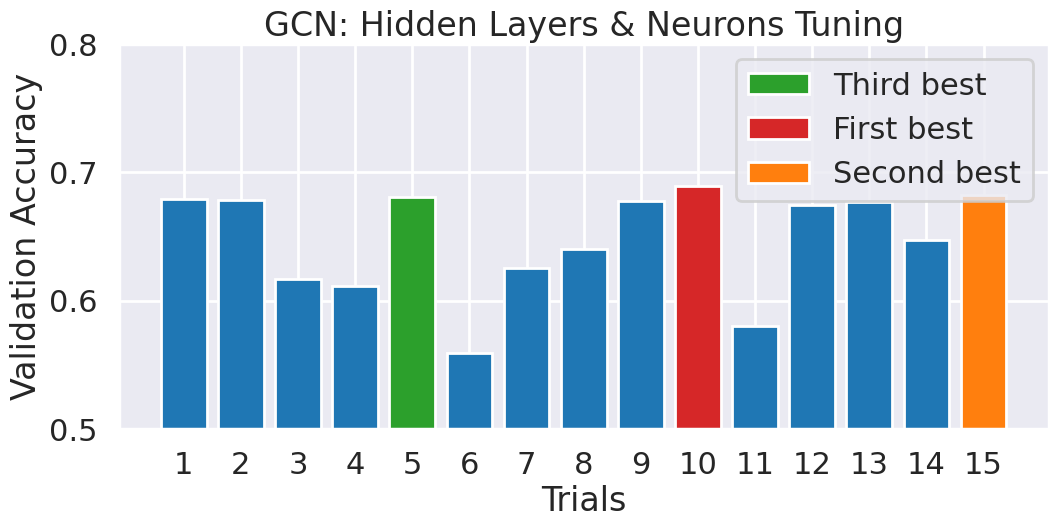

In [6]:
study1_df = study1.trials_dataframe()
study1_df_sort = study1_df.sort_values(by="value", ascending=False).reset_index()
top_three_expts = study1_df_sort["number"].to_numpy()[:3]

fig, ax = plt.subplots(figsize=(12,5))
x_values = [str(i+1) for i in study1_df["number"]]
bar_labels = []
bar_colors = []
for i in range(len(x_values)):
    if i == top_three_expts[0]:
        bar_labels.append("First best")
        bar_colors.append("tab:red")
    elif i == top_three_expts[1]:
        bar_labels.append("Second best")
        bar_colors.append("tab:orange")
    elif i == top_three_expts[2]:
        bar_labels.append("Third best")
        bar_colors.append("tab:green")
    else:
        bar_labels.append("_")
        bar_colors.append("tab:blue")

ax.bar(x_values, study1_df["value"], label=bar_labels, color=bar_colors)
ax.set_xlabel("Trials")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim([0.5, 0.8])
ax.set_title("GCN: Hidden Layers & Neurons Tuning")
ax.legend()

In [7]:
# Get the top 3 best hyperparameters from Study 1
for i, text in enumerate(["First", "Second", "Third"]):
    acc = study1_df_sort.value.iloc[i]
    if i == 0:
        print(f"\n\nFirst Best (val. acc. = {acc:.3f})")
    elif i == 1:
        print(f"\n\nSecond Best (val. acc. = {acc:.3f})")
    elif i == 2:
        print(f"\n\nThird Best (val. acc. = {acc:.3f})")
    print(f"----------------------------------")
    j = study1_df_sort.number.iloc[i]
    for param_name, param_value in study1.trials[j].params.items():
        if isinstance(param_value, float):
            print(f"{param_name} : {param_value:.3e}")
        else:
            print(f"{param_name} : {param_value}")



First Best (val. acc. = 0.690)
----------------------------------
num_hidden_layers : 3
neurons_1 : 32
neurons_2 : 64
neurons_3 : 16
dropout_prob : 2.848e-03


Second Best (val. acc. = 0.683)
----------------------------------
num_hidden_layers : 3
neurons_1 : 64
neurons_2 : 64
neurons_3 : 16
dropout_prob : 1.153e-03


Third Best (val. acc. = 0.681)
----------------------------------
num_hidden_layers : 3
neurons_1 : 16
neurons_2 : 64
neurons_3 : 16
dropout_prob : 3.251e-03


#### b) Tuning batch sizes and learning rate parameters

**Model architecture** (from above study):

- num_hidden_layers : 3
- neurons_1 : 32
- neurons_2 :  64
- neurons_3 :  16- dropout_prob : 2.848e-03

In [9]:
%%time

# Define the objective function for Optuna optimization
def objective_learn(trial):
    # Suggest hyperparameters to be optimized
    batch_size = trial.suggest_int('batch_size', 4, 256)
    lr = trial.suggest_float('lr', 1e-4, 0.1, log=True)
    lr_step = trial.suggest_int('lr_step', 50, 500)
    lr_gamma = trial.suggest_float('lr_gamma', 0.9, 1.0)
   
    # Train the model with suggested hyperparameters
    model = GCN(num_features=train_graph.x.shape[1], 
                num_classes=len(train_graph.y.unique()),
                dropout_prob=2.848e-03,
                num_hidden_layers=3,
                hidden_layer_neurons=[32, 64, 16]
               ).to(device)

    trained_model, stats = train(model,
                                 train_graph=train_graph,
                                 val_graph=val_graph,
                                 num_epochs=5000,
                                 batch_size=batch_size, 
                                 lr=lr, 
                                 lr_step=lr_step, 
                                 lr_gamma=lr_gamma, 
                                 display_freq=5000
                                )

    # Return the validation accuracy as the objective value to be maximized
    return stats['val']['accuracy'][-1]

# Perform Optuna study
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective_learn, n_trials=20)

[I 2023-12-15 22:13:33,654] A new study created in memory with name: no-name-66342112-dc04-44aa-bda4-088ce5df99ab
[I 2023-12-15 22:14:30,272] Trial 0 finished with value: 0.6836016096579477 and parameters: {'batch_size': 254, 'lr': 0.009237305344402516, 'lr_step': 318, 'lr_gamma': 0.9204153109181057}. Best is trial 0 with value: 0.6836016096579477.


Epoch 5000/5000 (learning rate: 2.663e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.794, 0.759] 	 Accuracy [Train, Val]: [0.674, 0.684]



[I 2023-12-15 22:15:33,063] Trial 1 finished with value: 0.5653923541247485 and parameters: {'batch_size': 195, 'lr': 0.0004292787836128668, 'lr_step': 192, 'lr_gamma': 0.9147391600192278}. Best is trial 0 with value: 0.6836016096579477.


Epoch 5000/5000 (learning rate: 4.231e-05)
----------------------------------------------------------
Loss [Train, Val]: [1.033, 1.027] 	 Accuracy [Train, Val]: [0.565, 0.565]



[I 2023-12-15 22:16:36,954] Trial 2 finished with value: 0.6680080482897385 and parameters: {'batch_size': 226, 'lr': 0.003561425066759362, 'lr_step': 296, 'lr_gamma': 0.9280696112101647}. Best is trial 0 with value: 0.6836016096579477.


Epoch 5000/5000 (learning rate: 1.079e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.799, 0.765] 	 Accuracy [Train, Val]: [0.659, 0.668]



[I 2023-12-15 22:17:40,594] Trial 3 finished with value: 0.6629778672032193 and parameters: {'batch_size': 5, 'lr': 0.0032081171938121234, 'lr_step': 267, 'lr_gamma': 0.9063868924118341}. Best is trial 0 with value: 0.6836016096579477.


Epoch 5000/5000 (learning rate: 5.469e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.840, 0.812] 	 Accuracy [Train, Val]: [0.657, 0.663]



[I 2023-12-15 22:18:45,245] Trial 4 finished with value: 0.6483903420523138 and parameters: {'batch_size': 253, 'lr': 0.03385583848804186, 'lr_step': 470, 'lr_gamma': 0.9678134073184164}. Best is trial 0 with value: 0.6836016096579477.


Epoch 5000/5000 (learning rate: 2.441e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.833, 0.820] 	 Accuracy [Train, Val]: [0.651, 0.648]



[I 2023-12-15 22:19:48,741] Trial 5 finished with value: 0.5523138832997988 and parameters: {'batch_size': 180, 'lr': 0.00028515719166008566, 'lr_step': 180, 'lr_gamma': 0.9438744974856513}. Best is trial 0 with value: 0.6836016096579477.


Epoch 5000/5000 (learning rate: 5.995e-05)
----------------------------------------------------------
Loss [Train, Val]: [1.052, 1.048] 	 Accuracy [Train, Val]: [0.549, 0.552]



[I 2023-12-15 22:20:51,846] Trial 6 finished with value: 0.6504024144869215 and parameters: {'batch_size': 135, 'lr': 0.008810456982637252, 'lr_step': 280, 'lr_gamma': 0.9023772791253563}. Best is trial 0 with value: 0.6836016096579477.


Epoch 5000/5000 (learning rate: 1.537e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.875, 0.825] 	 Accuracy [Train, Val]: [0.642, 0.650]



[I 2023-12-15 22:21:55,202] Trial 7 finished with value: 0.6891348088531187 and parameters: {'batch_size': 66, 'lr': 0.009114866697692141, 'lr_step': 483, 'lr_gamma': 0.9186314903702515}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 3.901e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.749, 0.724] 	 Accuracy [Train, Val]: [0.681, 0.689]



[I 2023-12-15 22:22:57,969] Trial 8 finished with value: 0.6227364185110664 and parameters: {'batch_size': 226, 'lr': 0.0007053804122139389, 'lr_step': 366, 'lr_gamma': 0.9045889556587355}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 1.916e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.943, 0.924] 	 Accuracy [Train, Val]: [0.622, 0.623]



[I 2023-12-15 22:23:55,774] Trial 9 finished with value: 0.5628772635814889 and parameters: {'batch_size': 237, 'lr': 0.0003544283201546645, 'lr_step': 175, 'lr_gamma': 0.958206308095229}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 1.072e-04)
----------------------------------------------------------
Loss [Train, Val]: [1.037, 1.027] 	 Accuracy [Train, Val]: [0.562, 0.563]



[I 2023-12-15 22:24:51,760] Trial 10 finished with value: 0.5633802816901409 and parameters: {'batch_size': 35, 'lr': 0.08301420529257583, 'lr_step': 474, 'lr_gamma': 0.9996119785872303}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 8.269e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.038, 1.047] 	 Accuracy [Train, Val]: [0.571, 0.563]



[I 2023-12-15 22:25:47,891] Trial 11 finished with value: 0.6690140845070423 and parameters: {'batch_size': 72, 'lr': 0.011601924688005433, 'lr_step': 396, 'lr_gamma': 0.9250954724964014}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 4.558e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.823, 0.800] 	 Accuracy [Train, Val]: [0.661, 0.669]



[I 2023-12-15 22:26:45,472] Trial 12 finished with value: 0.6177062374245473 and parameters: {'batch_size': 97, 'lr': 0.01586919447494557, 'lr_step': 57, 'lr_gamma': 0.9293532184476828}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 2.706e-05)
----------------------------------------------------------
Loss [Train, Val]: [0.911, 0.894] 	 Accuracy [Train, Val]: [0.613, 0.618]



[I 2023-12-15 22:27:44,566] Trial 13 finished with value: 0.6529175050301811 and parameters: {'batch_size': 143, 'lr': 0.0013774232209588272, 'lr_step': 394, 'lr_gamma': 0.9197898101683013}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 5.050e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.864, 0.849] 	 Accuracy [Train, Val]: [0.640, 0.653]



[I 2023-12-15 22:28:40,730] Trial 14 finished with value: 0.5291750503018109 and parameters: {'batch_size': 86, 'lr': 0.00010232309532941015, 'lr_step': 345, 'lr_gamma': 0.9348420535541533}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 3.984e-05)
----------------------------------------------------------
Loss [Train, Val]: [1.109, 1.109] 	 Accuracy [Train, Val]: [0.528, 0.529]



[I 2023-12-15 22:29:36,604] Trial 15 finished with value: 0.6810865191146881 and parameters: {'batch_size': 45, 'lr': 0.00631642525495651, 'lr_step': 500, 'lr_gamma': 0.9157312758151337}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 2.619e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.768, 0.751] 	 Accuracy [Train, Val]: [0.679, 0.681]



[I 2023-12-15 22:30:33,070] Trial 16 finished with value: 0.6790744466800804 and parameters: {'batch_size': 174, 'lr': 0.024828183787459303, 'lr_step': 432, 'lr_gamma': 0.9400373955887059}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 1.258e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.785, 0.761] 	 Accuracy [Train, Val]: [0.666, 0.679]



[I 2023-12-15 22:31:29,694] Trial 17 finished with value: 0.6066398390342053 and parameters: {'batch_size': 110, 'lr': 0.00539703141310318, 'lr_step': 56, 'lr_gamma': 0.9166902300939553}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 2.344e-06)
----------------------------------------------------------
Loss [Train, Val]: [0.960, 0.954] 	 Accuracy [Train, Val]: [0.607, 0.607]



[I 2023-12-15 22:32:26,228] Trial 18 finished with value: 0.6629778672032193 and parameters: {'batch_size': 62, 'lr': 0.0022027843847388243, 'lr_step': 325, 'lr_gamma': 0.9000637004435453}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 4.540e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.830, 0.809] 	 Accuracy [Train, Val]: [0.662, 0.663]



[I 2023-12-15 22:33:22,897] Trial 19 finished with value: 0.670523138832998 and parameters: {'batch_size': 5, 'lr': 0.012298025351684106, 'lr_step': 240, 'lr_gamma': 0.9353263386979795}. Best is trial 7 with value: 0.6891348088531187.


Epoch 5000/5000 (learning rate: 3.229e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.801, 0.771] 	 Accuracy [Train, Val]: [0.662, 0.671]

CPU times: user 17min 37s, sys: 2min 8s, total: 19min 46s
Wall time: 19min 49s


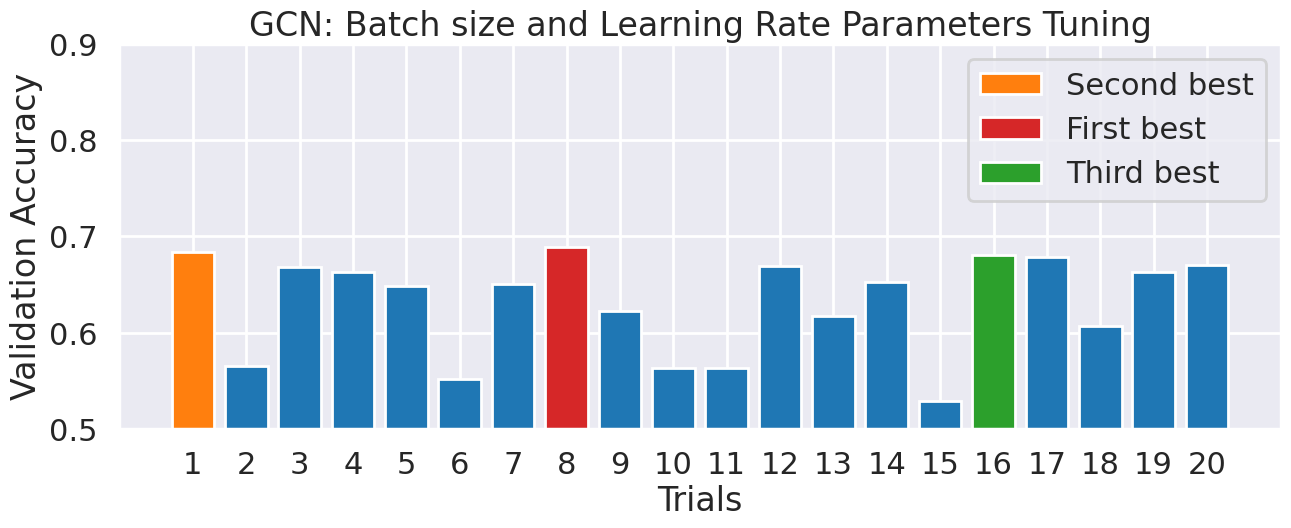

In [10]:
study2_df = study2.trials_dataframe()
study2_df_sort = study2_df.sort_values(by="value", ascending=False).reset_index()
top_three_expts = study2_df_sort["number"].to_numpy()[:3]

fig, ax = plt.subplots(figsize=(15,5))
x_values = [str(i+1) for i in study2_df["number"]]
bar_labels = []
bar_colors = []
for i in range(len(x_values)):
    if i == top_three_expts[0]:
        bar_labels.append("First best")
        bar_colors.append("tab:red")
    elif i == top_three_expts[1]:
        bar_labels.append("Second best")
        bar_colors.append("tab:orange")
    elif i == top_three_expts[2]:
        bar_labels.append("Third best")
        bar_colors.append("tab:green")
    else:
        bar_labels.append("_")
        bar_colors.append("tab:blue")

ax.bar(x_values, study2_df["value"], label=bar_labels, color=bar_colors)
ax.set_xlabel("Trials")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim([0.5, 0.9])
ax.set_title("GCN: Batch size and Learning Rate Parameters Tuning")
ax.legend()

In [11]:
# Get the top 3 best hyperparameters from Study 2
for i, text in enumerate(["First", "Second", "Third"]):
    acc = study2_df_sort.value.iloc[i]
    if i == 0:
        print(f"\n\nFirst Best (val. acc. = {acc:.5f})")
    elif i == 1:
        print(f"\n\nSecond Best (val. acc. = {acc:.5f})")
    elif i == 2:
        print(f"\n\nThird Best (val. acc. = {acc:.5f})")
    print(f"----------------------------------")
    j = study2_df_sort.number.iloc[i]
    for param_name, param_value in study2.trials[j].params.items():
        if isinstance(param_value, float):
            print(f"{param_name} : {param_value:.3e}")
        else:
            print(f"{param_name} : {param_value}")



First Best (val. acc. = 0.68913)
----------------------------------
batch_size : 66
lr : 9.115e-03
lr_step : 483
lr_gamma : 9.186e-01


Second Best (val. acc. = 0.68360)
----------------------------------
batch_size : 254
lr : 9.237e-03
lr_step : 318
lr_gamma : 9.204e-01


Third Best (val. acc. = 0.68109)
----------------------------------
batch_size : 45
lr : 6.316e-03
lr_step : 500
lr_gamma : 9.157e-01


### Final GCN Model

From above studies, we have

**Model architecture**:

- num_hidden_layers : 3
- neurons_1 : 32
- neurons_2 :  64
- neurons_3 :  16
- dropout_prob : 2.848e-03

**Training**:

- batch_size : 66- lr : 9.115e-03
- lr_step : 438
- lr_gamma : 9.186e-01